In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import stripROtools
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from scipy.optimize import curve_fit
from scipy.stats import crystalball

from stripROtools import colors
from stripROtools import GetTransErrs
from stripROtools import Mismeasurment_vs_z
from stripROtools import random_three_vector
from stripROtools import plot_track

In [59]:
# Solid angle range in theta [degrees]
theta_min = 15
theta_max = 30

# dataframe with time offset info used for 3D reconstruction
T_off = pd.read_pickle("./data/time_offset.pk")
T_off

,Name,Mu,Mu_err,Sigma,Sigma_err
0,UH DLC a,-6.684141,0.031719,16.382493,0.024764
1,UH DLC b,-5.208232,0.034228,16.305925,0.026783
2,UH DLC c,6.752723,0.038583,14.113659,0.031446
3,UH DLC d,6.852294,0.058807,14.800689,0.048234
4,UH NoDLC a,5.703480,0.075588,19.574833,0.061573
5,UH NoDLC b,5.473110,0.114114,19.799337,0.092169
6,UH NoDLC c,25.241775,0.189180,18.082547,0.159142
7,UH NoDLC d,20.674842,0.698955,17.886667,0.626167
8,UoS,-11.400385,0.026963,15.290716,0.021079


# Read dE/dx data from SRIM

In [60]:
# Load dEdx data simulated with SRIM
dEdx_data = np.loadtxt("./data/srim_po210_heco2.txt",skiprows=4)

dEdx_data = dEdx_data.T

# convert from angstrom to cm
dEdx_data[0] = dEdx_data[0]*1e-8

#dEdx resolution as seen in dEdx_data[0] 
delta_x = 0.1

# convert to eV/cm
dEdx_data[1] = dEdx_data[1]/1e-8
dEdx_data[2] = dEdx_data[2]/1e-8

dEdx = dEdx_data[1] + dEdx_data[2]




Text(0, 0.5, 'dE/dx [eV/cm] ')

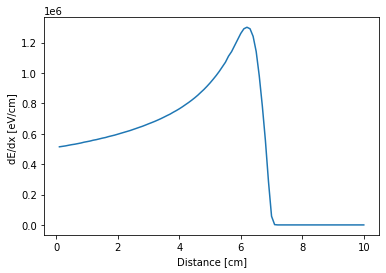

In [61]:
plt.plot(dEdx_data[0],dEdx)
plt.xlabel("Distance [cm]")
plt.ylabel("dE/dx [eV/cm] ")


# Simulate Po210 alpha tracks

In [62]:
# The paramters, in order, are:
# number of simulations
# minimum angle to vertical [degrees] - this is based  on requiring a min. of 5 hits
# maximum angle to vertical [degrees]
# drfit length [cm]
# Apply diffusion T/F
# Transverse diffusion coefficent from Magboltz [cm/sqrt(cm)]
# W-value as obtained using degrad

def sim_p210(n_sims = 100, theta_min = theta_min, theta_max = theta_max, DL = 1.2, Diff = True, DTrans = 0.0135, DLong = 0.0129, W = 35.2):

    tracks = pd.DataFrame(columns = ['direction', 'start', 'track'])

    for i in range(n_sims):

        # draw a random direction within specified solid angle (pointing down towards the readout plane)
        v = random_three_vector(theta_min,theta_max)

        # Maximumm track length of alpha track
        L_max = -DL/v[2]

        # Length segments we will distribute charge on, 0.1 is the resolution of length of the SRIM simulation
        L_segments = np.arange(0,L_max+0.1,0.1)

        # Edges of the length segments we will distribute charge on (all edges are listed)
        L_edges = np.append(L_segments,L_max)

        # Energy deposited in each segment given dEdx (energy in each bin is listed)
        E_segments = dEdx[0:len(L_segments)]*np.diff(L_edges)

        # Compute corresponding number of ionizaed eletrons using energy deposited per segment divided by W-value
        Ne_segments = np.round(E_segments/W).astype("int")

        #find left and right edges for each bin
        Left_edges = L_segments[0:-1]
        Right_edges = L_segments[1:]

        track = np.empty((0,3))

        for N,left_edge,right_edge in zip(Ne_segments,Left_edges,Right_edges):

            Ts = np.random.uniform(low=left_edge,high=right_edge,size=N)

            if Diff == False:

                x_vals = Ts*v[0]
                y_vals = Ts*v[1]
                z_vals = DL + Ts*v[2]

                Track_segment = np.array([x_vals,y_vals,z_vals]).T

                track = np.append(track,Track_segment,axis=0)
            
            elif Diff == True:

                z_vals = DL + Ts*v[2]

                x_vals = Ts*v[0] + DTrans*np.sqrt(np.abs(z_vals))*np.random.normal(size=len(Ts))
                y_vals = Ts*v[1] + DTrans*np.sqrt(np.abs(z_vals))*np.random.normal(size=len(Ts))
                z_vals = z_vals + DLong*np.sqrt(np.abs(z_vals))*np.random.normal(size=len(Ts))

                Track_segment = np.array([x_vals,y_vals,z_vals]).T

                track = np.append(track,Track_segment,axis=0)

        x_rand = np.random.uniform()-0.5
        y_rand = np.random.uniform()-0.5

        track[:,0] = track[:,0]+x_rand # randomize x position (1 cm random uniform dist)
        track[:,1] = track[:,1]+y_rand # randomize x position (1 cm random uniform dist)

        tracks = tracks.append({'direction' : v, 'start' : np.array([x_rand,y_rand,DL]), 'track' : track }, ignore_index = True)

    return tracks




In [63]:
# Example of track simulation
tracks = sim_p210(n_sims = 100)
tracks.head()

,direction,start,track
0,"[0.421574404797147, 0.197310246331867, -0.8850...","[0.4550558756774643, -0.33024976113721916, 1.2]","[[0.46380276167980566, -0.35525469603729604, 1..."
1,"[-0.4486847775363206, -0.13495511324439524, -0...","[-0.1581219980045212, -0.3559500401988548, 1.2]","[[-0.20595225334603637, -0.36683877355631256, ..."
2,"[0.12889021373241105, 0.454445722574178, -0.88...","[0.43605803181768354, -0.2720039852781079, 1.2]","[[0.4605040920042702, -0.28017382162130533, 1...."
3,"[-0.0780918123321734, 0.3045616373810494, -0.9...","[0.4857960415877507, 0.057546034200503526, 1.2]","[[0.46102290980065586, 0.11454987045650501, 1...."
4,"[-0.28690184619709347, 0.16671321371780062, -0...","[-0.20375836553335447, -0.14199688363194118, 1.2]","[[-0.21756162871885454, -0.13630936245398462, ..."


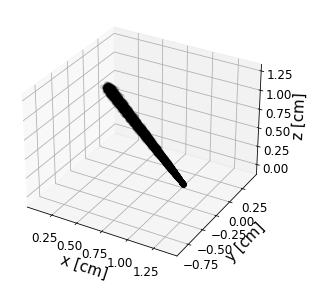

In [64]:
# Plot a Track
index = 0
track = tracks.iloc[index]["track"]
plot_track(track)

# Simulate readout


In [65]:
# the parameters, in order, are:
# peaking time [ns]
# digitization time [ns] 
# pitch of the x strips [um]
# pitch of the y strips [um]
# Threshold of x strips [No. electrons]
# Threshold of y strips [No. electrons]
# Charge sharing [lower strips / upper strips]
# Gain - extrapolating from PHA curve
# drift speed cm/ns
# Include charge integration effect.
# z resolution in cm, must be specified if Charge_integration = False
# Electronic gain in x [mV/fC]
# Electronic gain in y [mV/fC]

def sim_readout(tracks, peaking_time = 200, digit_t  = 250, pitch_x = 200, pitch_y = 200,thres_x = 82/9.0*6241.5, thres_y =  82/4.5*6241.5, CS = 0.62, Gain = 505.7, v_drift = 0.0008, Charge_integration = True, DL = 1.2, pitch_z = 0.02, G_x = 9.0, G_y = 4.5):

    #convert pitch to cm
    pitch_x = pitch_x * 1e-4
    pitch_y = pitch_y * 1e-4
    
    # Readout is 10 cm x 10 cm
    x_bins = np.arange(-5,5,pitch_x)
    y_bins = np.arange(-5,5,pitch_y)

    # Find strip edges in x and y
    Left_edges_x = x_bins[0:-1]
    Right_edges_x = x_bins[1:]
    Left_edges_y = y_bins[0:-1]
    Right_edges_y = y_bins[1:]


    hits = pd.DataFrame(columns = ['strips_x', 'strips_y', 'times_x', 'times_y','electrons_x','electrons_y'])

    for index, row in tracks.iterrows():

        track = row.track

        x_positions = []
        x_charges = []
        x_times = []
        adcs0 = []
        strips0 = []

        for L_edge,R_edge in zip(Left_edges_x,Right_edges_x):

            # Bin track over specific strip in x
            T_track = track[(track[:,0]> L_edge) &  (track[:,0]< R_edge)]

            # If there is charge above this strip
            if len(T_track > 0):


                # If we are incuding the effects of finite charge integration time followed by digitization time
                if Charge_integration == True:

                    # Get time distribution of charge over this strip
                    time_dist = T_track[:,2]/v_drift

                    # Shift so that min is t = 0ns
                    min_time = np.min(time_dist)
                    time_dist= time_dist-min_time

                    # Keeping only the charge withing peaking time
                    time_dist = time_dist [time_dist < peaking_time]

                    # compute mean time for the hit
                    mean_time = np.mean(time_dist)+min_time

                    # obtain detected charge taking into account primary ionization, gain, and charge sharing
                    charge_detected = len(time_dist) *Gain * CS / (CS+1.0)

                    if charge_detected > thres_x:
                        
                        # obtain mean time for the hit
                        x_times += [mean_time]
                        # obtain position of the hit
                        x_positions += [ (L_edge+R_edge)/2.0 ]
                        # Position expressed consistently with exp digitized data
                        strips0 += [np.where(x_bins == L_edge)[0][0]]
                        # obtain detected charge taking into account primary ionization, gain, and charge sharing
                        x_charges += [ charge_detected ]
                        # Charge expressed consistently with exp digitized data
                        adcs0 += [min( charge_detected/6241.5*G_x, 1023.0 ) ]

                # Otherwise we bin the time axis according to the specified z resolution
                else:

                    # Bin in the z-dimension
                    z_bins = np.arange(0,DL+pitch_z,pitch_z)
                    hist, bin_edges = np.histogram(T_track[:,2],bins=z_bins)
                    bin_centers = (bin_edges[1:]+bin_edges[:-1])/2

                    bin_centers = bin_centers[hist>0]
                    hist = hist[hist>0]

                    charge_detected = hist *Gain * CS / (CS+1.0)

                    # only keep hits above threshol
                    bin_centers = bin_centers[charge_detected>thres_x]
                    charge_detected = charge_detected [charge_detected>thres_x]


                    x_times += list(bin_centers/v_drift)
                    x_positions += list( np.ones(len(bin_centers)) * ((L_edge+R_edge)/2.0) )
                    x_charges += list(charge_detected)

        

        y_positions = []
        y_charges = []
        y_times = []
        adcs1 = []
        strips1 = []

        for L_edge,R_edge in zip(Left_edges_y,Right_edges_y):

            # Bin track over specific strip in x
            T_track = track[(track[:,1]> L_edge) &  (track[:,1]< R_edge)]

            # If there is charge above this strip
            if len(T_track > 0):

                # If we are incuding the effects of finite charge integration time followed by digitization time
                if Charge_integration == True:

                    # Get time distribution of charge over this strip
                    time_dist = T_track[:,2]/v_drift

                    # Shift so that min is t = 0ns
                    min_time = np.min(time_dist)
                    time_dist= time_dist-min_time

                    # Keeping only the charge withing peaking time
                    time_dist = time_dist [time_dist < peaking_time]

                    # compute mean time for the hit
                    mean_time = np.mean(time_dist)+min_time

                    # obtain detected charge taking into account primary ionization, gain, and charge sharing
                    charge_detected = len(time_dist) * Gain / (CS+1.0)

                    if charge_detected > thres_y:

                        # obtain mean time for the hit
                        y_times += [mean_time]
                        # obtain position of the hit
                        y_positions += [ (L_edge+R_edge)/2.0 ]
                        # Position expressed consistently with exp digitized data
                        strips1 += [np.where(y_bins == L_edge)[0][0]]
                        # obtain detected charge taking into account primary ionization, gain, and charge sharing
                        y_charges += [ charge_detected ]
                        # Charge expressed consistently with exp digitized data
                        adcs1 += [ min( charge_detected/6241.5*G_y, 1023.0 ) ] # The min imposes saturation of ADC scale

                # Otherwise we bin the time axis according to the specified z resolution
                else:

                    # Bin in the z-dimension
                    z_bins = np.arange(0,DL+pitch_z,pitch_z)
                    hist, bin_edges = np.histogram(T_track[:,2],bins=z_bins)
                    bin_centers = (bin_edges[1:]+bin_edges[:-1])/2

                    bin_centers = bin_centers[hist>0]
                    hist = hist[hist>0]

                    charge_detected = hist * Gain / (CS+1.0)

                    # only keep hits above threshol
                    bin_centers = bin_centers[charge_detected>thres_y]
                    charge_detected = charge_detected [charge_detected>thres_y]


                    y_times += list(bin_centers/v_drift)
                    y_positions += list( np.ones(len(bin_centers)) * ((L_edge+R_edge)/2.0) )
                    y_charges += list(charge_detected)

        hits = hits.append({'strips_x' : np.array(x_positions), 'strips0' : np.array(strips0),  'strips_y' : np.array(y_positions), 'strips1' : np.array(strips1), 'times_x' : np.array(x_times), 'times0' : np.array(x_times), 'times_y' : np.array(y_times), 'times1' : np.array(y_times), 'electrons_x' :  np.array(x_charges), 'adcs0' :  np.array(adcs0), 'electrons_y' : np.array(y_charges), 'adcs1' :  np.array(adcs1) }, ignore_index = True)
        
    return hits


In [66]:
# Example of readout simulation
hits = sim_readout(tracks)
tracks = pd.concat([tracks,hits],axis=1)
tracks.head()


,direction,start,track,strips_x,strips_y,times_x,times_y,electrons_x,electrons_y,adcs0,adcs1,strips0,strips1,times0,times1
0,"[0.421574404797147, 0.197310246331867, -0.8850...","[0.4550558756774643, -0.33024976113721916, 1.2]","[[0.46380276167980566, -0.35525469603729604, 1...","[0.4699999999998834, 0.489999999999883, 0.5099...","[-0.2700000000001008, -0.23000000000010168, -0...","[1448.007653001919, 1395.7487034731867, 1354.3...","[1091.6928203473872, 861.1187324491714, 777.04...","[108962.74197530863, 112059.37407407406, 12889...","[211332.6543209876, 139847.9012345679, 257532....","[157.12003168753947, 161.58525461294025, 185.8...","[152.36672986372574, 100.82761444453345, 185.6...","[273, 274, 275, 276, 277, 278, 279, 280, 281, ...","[236, 238, 239, 240, 241, 242, 243, 244, 245, ...","[1448.007653001919, 1395.7487034731867, 1354.3...","[1091.6928203473872, 861.1187324491714, 777.04..."
1,"[-0.4486847775363206, -0.13495511324439524, -0...","[-0.1581219980045212, -0.3559500401988548, 1.2]","[[-0.20595225334603637, -0.36683877355631256, ...","[-0.7700000000000902, -0.7500000000000906, -0....","[-0.5500000000000949, -0.5300000000000953, -0....","[-6.347291033114118, 43.83353096098374, 93.803...","[-26.359251414476493, 66.83437952944442, 216.2...","[144574.0111111111, 128316.69259259258, 128897...","[171063.95061728393, 668647.7777777776, 560952...","[208.47009532964827, 185.02767497129426, 185.8...","[123.33377838304537, 482.08203156292547, 404.4...","[211, 212, 213, 214, 215, 216, 217, 218, 219, ...","[222, 223, 224, 225, 226, 227, 228]","[-6.347291033114118, 43.83353096098374, 93.803...","[-26.359251414476493, 66.83437952944442, 216.2..."
2,"[0.12889021373241105, 0.454445722574178, -0.88...","[0.43605803181768354, -0.2720039852781079, 1.2]","[[0.4605040920042702, -0.28017382162130533, 1....","[0.4499999999998838, 0.4699999999998834, 0.489...","[-0.25000000000010125, -0.23000000000010168, -...","[1188.2655235083253, 1032.7943039765325, 887.7...","[1441.0893435425307, 1400.4791033490387, 1348....","[66577.59012345679, 67351.74814814815, 87673.3...","[188857.09876543208, 189793.58024691357, 19666...","[96.00229289611649, 97.1185986274667, 126.4216...","[136.16229182799717, 136.83747674615253, 141.7...","[272, 273, 274, 275, 276, 277, 278, 279, 280]","[237, 238, 239, 240, 241, 242, 243, 244, 245, ...","[1188.2655235083253, 1032.7943039765325, 887.7...","[1441.0893435425307, 1400.4791033490387, 1348...."
3,"[-0.0780918123321734, 0.3045616373810494, -0.9...","[0.4857960415877507, 0.057546034200503526, 1.2]","[[0.46102290980065586, 0.11454987045650501, 1....","[0.3899999999998851, 0.4099999999998847, 0.429...","[0.06999999999989193, 0.0899999999998915, 0.10...","[50.61767150650752, 197.43801240964808, 432.61...","[1395.0481556136958, 1340.5390476154741, 1263....","[481332.7518518518, 155799.3024691358, 103156....","[135789.8148148148, 213205.6172839506, 187920....","[694.0630884669816, 224.6565284342261, 148.747...","[97.90181313252688, 153.71709970003647, 135.48...","[269, 270, 271]","[253, 254, 255, 256, 257, 259, 260, 261, 262, ...","[50.61767150650752, 197.43801240964808, 432.61...","[1395.0481556136958, 1340.5390476154741, 1263...."
4,"[-0.28690184619709347, 0.16671321371780062, -0...","[-0.20375836553335447, -0.14199688363194118, 1.2]","[[-0.21756162871885454, -0.13630936245398462, ...","[-0.5700000000000944, -0.5500000000000949, -0....","[-0.07000000000010509, -0.050000000000105516, ...","[1.2555834506636998, 78.66335702551045, 161.49...","[885.3400589926937, 737.8271019146871, 615.021...","[183088.37283950616, 213086.99629629625, 21676...","[155455.92592592593, 130483.08641975308, 14733...","[264.00630546432035, 307.2631525541402, 312.56...","[112.08069641378941, 94.07576526297986, 106.22...","[221, 222, 223, 224, 225, 226, 227, 228, 229, ...","[246, 247, 248, 249, 250, 251, 252, 253]","[1.2555834506636998, 78.66335702551045, 161.49...","[885.3400589926937, 737.8271019146871, 615.021..."


# Perform 3D Reconstruction

[   0.           77.40777357  160.24009796  240.17789156  322.80282662
  399.13699826  487.63108221  564.40291965  636.75147914  717.55844938
  801.89090105  868.39022658  948.27643635 1037.580413   1091.1616817
 1169.21302216 1260.75216688 1332.69260285 1424.18113087]


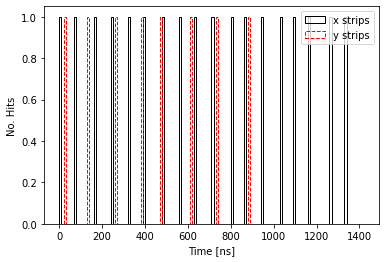

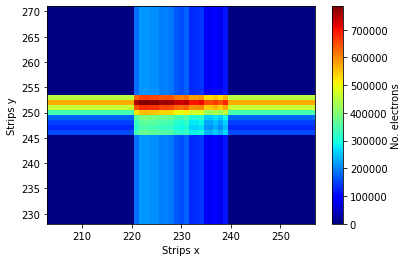

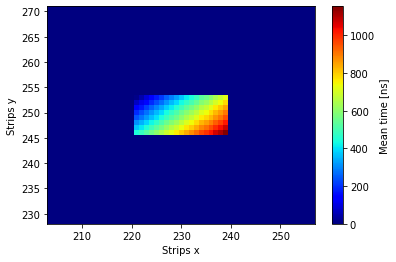

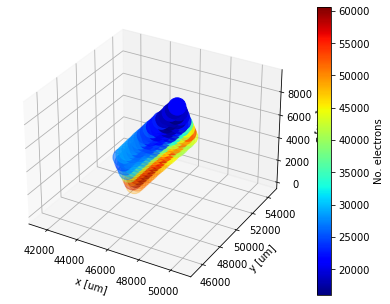

/Users/majdghrear/Lab/2DstripRO/stripROtools.py:663: RuntimeWarning: invalid value encountered in reciprocal
  abs_t_off = np.reciprocal(abs_t_off,where= abs_t_off!=0)


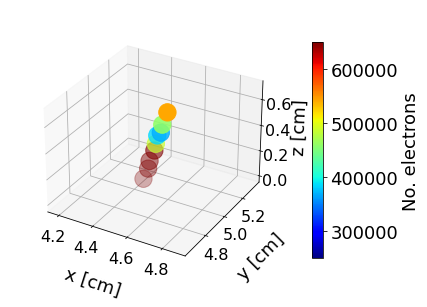

In [67]:
# 3D clustering paramters
mu = T_off.iloc[0]["Mu"]
sigma = T_off.iloc[0]["Sigma"]
n_sigma = 3

# Look at a single event after the cut
test_event = tracks.iloc[4]
# Make a TrackTools object for the event
dsp = stripROtools.TrackTools(event = test_event, Mult_factor = 1.0, gain_x=9, gain_y=4.5, v_drift=8.0)

# Plot 1D time display
dsp.TimeHistView( t_bin =10)

# Plot 2D displays of charge and time
dsp.Strip2DView(fullview = False)
dsp.Strip2DView_times(fullview = False)

# Plot 3D displays
dsp.Reconst3D_v0()
x,y,z,c = dsp.Reconst3D_v1( mu = mu, sigma = sigma , n_sigma = n_sigma,save_name = "sim_alpha")

# Assess point resolution versus absolute z

In [68]:
def get_PR(tracks, mu = -6.7, sigma = 16.4 , n_sigma = 3, G_x = 9.0, G_y = 4.5, n_strips_x = 500, n_strips_y=500, pitch_x=200, pitch_y=200, theta_min = theta_min, theta_max = theta_max):

    # Analyze point resolution
    all_z = np.array([])
    all_c = np.array([])
    all_x_err_1 = np.array([])
    all_y_err_1 = np.array([])
    all_x_err_2 = np.array([])
    all_y_err_2 = np.array([])



    for index, row in tracks.iterrows():

        try:
            # Make a TrackTools object for the event
            dsp = stripROtools.TrackTools(event = row, Mult_factor = 1.0, gain_x=G_x, gain_y=G_y, n_strips_x = n_strips_x, n_strips_y=n_strips_y, v_drift=8.0, pitch_x=pitch_x, pitch_y=pitch_y) # Mult factor always 1 for sim
            
            # Remove delayed hits (as discussed in the slides)
            dsp.prune_track(T_L = 0, T_H=250)
            dsp.prune_track2(gap=2)

            x,y,z,c = dsp.Reconst3D_v1( mu = mu, sigma = sigma , n_sigma = n_sigma, plot = False)

            
            # Only consider tracks with 5 or more points 
            if len(x) > 5:

                # Get mismeasurements and absolute z values
                z_vals, delta_xs_1, delta_ys_1, delta_xs_2, delta_ys_2, v_PA, x_b = stripROtools.GetTransErrs( x,y,z,c, charge_weighting = True)
                
                # Angle to vertical
                ang_z = np.arccos(v_PA[2])*57.2958

                if (ang_z>theta_min) and (ang_z<theta_max):
            
                    all_z = np.append(all_z,z_vals)
                    all_c = np.append(all_c,c)
                    all_x_err_1 = np.append(all_x_err_1,delta_xs_1)
                    all_y_err_1 = np.append(all_y_err_1,delta_ys_1)
                    all_x_err_2 = np.append(all_x_err_2,delta_xs_2)
                    all_y_err_2 = np.append(all_y_err_2,delta_ys_2)
                

            
        except:
            pass

    # Switch to cm
    all_z = all_z*1E-4

    # Get mismeasurement versus abs. z using method 1
    abs_z, x_sigmas2, x_sigmas_err2, y_sigmas2, y_sigmas_err2, abs_z_std, x_std, y_std = stripROtools.Mismeasurment_vs_z_weighted(z_vals=all_z, x_mis=all_x_err_2 , y_mis = all_y_err_2, charge = all_c, start = 0.0, stop = 1.2, step = 0.2,plot=False)



    plt.figure()
    plt.errorbar(abs_z,np.abs(x_sigmas2),x_sigmas_err2, color=colors["blue"],fmt='o',label="x strips", capthick=2)
    plt.errorbar(abs_z,np.abs(y_sigmas2),y_sigmas_err2, color=colors["red"],fmt='o',label="y strips", capthick=2)
    #plt.plot(abs_z_std,x_std,color=colors["blue"])
    #plt.plot(abs_z_std,y_std,color=colors["red"])
    plt.legend()
    plt.ylim((0,200))
    plt.xlabel("Abs. z [cm]")
    plt.ylabel("Effective Point Resolution [um]")
    plt.show()

    return np.abs(x_sigmas2), x_sigmas_err2, np.abs(y_sigmas2), y_sigmas_err2, abs_z

sigma x:  38.524007132875916 +/- 0.002495148798554216
sigma y:  40.55807011508522 +/- 0.0026296671914386492
sigma x:  31.64785757081755 +/- 0.0019489877485168855
sigma y:  -42.289629194364316 +/- 0.0032333337166124657
sigma x:  39.72930443615112 +/- 0.003338937857928679
sigma y:  43.487444384715054 +/- 0.003966174157157915
sigma x:  40.11520307217932 +/- 0.0039690468681110305
sigma y:  44.72441968833014 +/- 0.005359555684040474
sigma x:  43.063703068277015 +/- 0.006061020442447688
sigma y:  52.73623107596427 +/- 0.009448110389470958
sigma x:  47.65326469327156 +/- 0.009700714131312873
sigma y:  46.58202341592907 +/- 0.009571192178985466


/Users/majdghrear/Lab/2DstripRO/stripROtools.py:663: RuntimeWarning: invalid value encountered in reciprocal
  abs_t_off = np.reciprocal(abs_t_off,where= abs_t_off!=0)


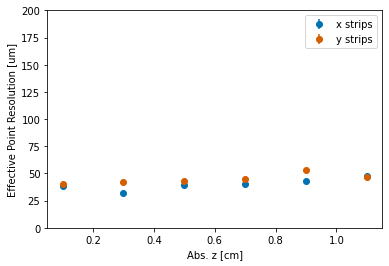

In [69]:
# Example point res calc
x_res, x_res_err, y_res, y_res_err, abs_z = get_PR(tracks)

# Simulate Po210 in UH DLC Quadrant a



In [81]:
# Make dataframe to store all results

df_resolution = pd.DataFrame(columns = ['Name','x_res', 'x_res_err', 'y_res', 'y_res_err','abs_z'])

sigma x:  38.77810545176335 +/- 0.0007765748978853815
sigma y:  40.7902965897492 +/- 0.0009326616105153065
sigma x:  -35.22943553467575 +/- 0.0008391479314021729
sigma y:  38.72557396847153 +/- 0.0008739772390221997
sigma x:  38.08637781189536 +/- 0.0010352395636745787
sigma y:  43.55672646507416 +/- 0.0012460286030422647
sigma x:  -38.86979397502497 +/- 0.0013324217603751913
sigma y:  42.18276759587272 +/- 0.0012826063756724076
sigma x:  41.322622230655014 +/- 0.0016104628930621312
sigma y:  43.035059409241995 +/- 0.0016829136219194299
sigma x:  47.29631433591054 +/- 0.002356703935055055
sigma y:  -48.27323642520494 +/- 0.0024923046525305538


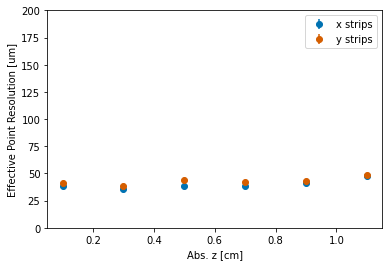

In [82]:
Charge_sharing = 0.41
Gain = 505.7
pitch_x = 200               # in um
pitch_y = 200               # in um
n_strips_x = 500
n_strips_y = 500
electronic_gain_x = 9.0     # in mV/fC
electronic_gain_y = 4.5     # in mV/fC

# 3D clustering paramters
mu = T_off.iloc[0]["Mu"]
sigma = T_off.iloc[0]["Sigma"]
n_sigma = 3

# simulatue tracks
tracks = sim_p210(n_sims = 500, DL = 1.2, Diff = True, DTrans = 0.0135, DLong = 0.0129, W = 35.2)

# simulate readout
hits = sim_readout(tracks, peaking_time = 200, digit_t  = 250, pitch_x = pitch_x, pitch_y = pitch_y,thres_x = 82/electronic_gain_x*6241.5, thres_y =  82/electronic_gain_y*6241.5, CS = Charge_sharing, Gain = Gain, v_drift = 0.0008, Charge_integration = True, pitch_z = 0.02, G_x = electronic_gain_x, G_y = electronic_gain_x)
tracks = pd.concat([tracks,hits],axis=1)


# Reconstruct and get point resolutions
x_res, x_res_err, y_res, y_res_err, abs_z = get_PR(tracks, mu = mu, sigma = sigma , n_sigma = n_sigma, G_x = electronic_gain_x, G_y = electronic_gain_y, n_strips_x = n_strips_x, n_strips_y=n_strips_y, pitch_x=pitch_x, pitch_y=pitch_y, theta_min = theta_min, theta_max = theta_max)


df_resolution = df_resolution.append({'Name' : "UH_DLC_a", 'x_res' : x_res, 'x_res_err' : x_res_err, 'y_res' : y_res, 'y_res_err' :  y_res_err, 'abs_z' : abs_z }, ignore_index = True)



# Simulate Po210 in UH NoDLC Quadrant a

sigma x:  43.61871777026019 +/- 0.000706572985031821
sigma y:  44.29153976421668 +/- 0.0006854052676493003
sigma x:  -41.57178281767986 +/- 0.0008616424104633634
sigma y:  -46.06120528985288 +/- 0.0008841854342560201
sigma x:  41.17920784240863 +/- 0.0008263700147635946
sigma y:  -42.49800366461796 +/- 0.0007966423582849967
sigma x:  -42.09170970962013 +/- 0.0010244241691615137
sigma y:  47.13744508572537 +/- 0.0011952811770136814
sigma x:  46.48494596731386 +/- 0.0015023570875842165
sigma y:  -50.08826523749481 +/- 0.0016155488368099708
sigma x:  52.25700926103647 +/- 0.0021683972122544934
sigma y:  56.12971159268936 +/- 0.0022353919860319997


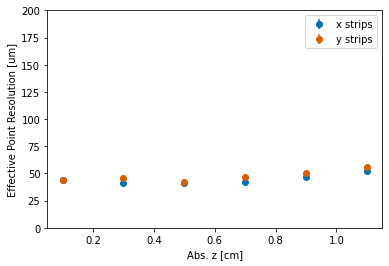

In [83]:
Charge_sharing = 0.62
Gain = 630.8
pitch_x = 200
pitch_y = 200
n_strips_x = 500
n_strips_y = 500
electronic_gain_x = 9.0
electronic_gain_y = 4.5


# 3D clustering paramters
mu = T_off.iloc[4]["Mu"]
sigma = T_off.iloc[4]["Sigma"]
n_sigma = 3

# simulatue tracks
tracks = sim_p210(n_sims = 500, DL = 1.2, Diff = True, DTrans = 0.0135, DLong = 0.0129, W = 35.2)

# simulate readout
hits = sim_readout(tracks, peaking_time = 200, digit_t  = 250, pitch_x = pitch_x, pitch_y = pitch_y,thres_x = 82/electronic_gain_x*6241.5, thres_y =  82/electronic_gain_y*6241.5, CS = Charge_sharing, Gain = Gain, v_drift = 0.0008, Charge_integration = True, pitch_z = 0.02, G_x = electronic_gain_x, G_y = electronic_gain_x)
tracks = pd.concat([tracks,hits],axis=1)

# Reconstruct and get point resolutions
x_res, x_res_err, y_res, y_res_err, abs_z = get_PR(tracks, mu = mu, sigma = sigma , n_sigma = n_sigma, G_x = electronic_gain_x, G_y = electronic_gain_y, n_strips_x = n_strips_x, n_strips_y=n_strips_y, pitch_x=pitch_x, pitch_y=pitch_y, theta_min = theta_min, theta_max = theta_max )

df_resolution = df_resolution.append({'Name' : "UH_NoDLC_a", 'x_res' : x_res, 'x_res_err' : x_res_err, 'y_res' : y_res, 'y_res_err' :  y_res_err, 'abs_z' : abs_z }, ignore_index = True)



# Simulate Po210 in UoS

sigma x:  38.33678984026937 +/- 0.0003466565065767244
sigma y:  41.7026477542917 +/- 0.0004015573023818841
sigma x:  34.36161870947947 +/- 0.000335634590370781
sigma y:  36.34327814478202 +/- 0.00033888198866150913
sigma x:  36.294475373032725 +/- 0.0004037862097849225
sigma y:  -35.6811034260078 +/- 0.0003944293064927488
sigma x:  37.537413617208 +/- 0.00048687836096697685
sigma y:  38.11610927474841 +/- 0.0005003492870334891
sigma x:  -41.09803645652644 +/- 0.0007725721995916186
sigma y:  43.2618108428934 +/- 0.0007669153658491276
sigma x:  40.872156167473385 +/- 0.0010498997579690287
sigma y:  46.62978315450982 +/- 0.0012242909886406052


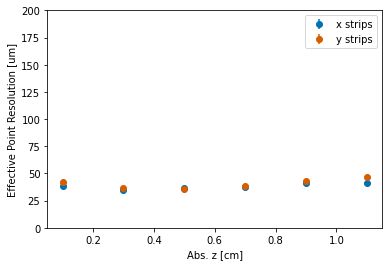

In [84]:
Charge_sharing = 0.13
Gain = 6490
pitch_x = 250
pitch_y = 250
n_strips_x = 358
n_strips_y = 358
electronic_gain_x 
electronic_gain_x= 1.0
electronic_gain_y = 1.0

# 3D clustering paramters
mu = T_off.iloc[8]["Mu"]
sigma = T_off.iloc[8]["Sigma"]
n_sigma = 3

# simulatue tracks
tracks = sim_p210(n_sims = 500, DL = 1.2, Diff = True, DTrans = 0.0135, DLong = 0.0129, W = 35.2)

# simulate readout
hits = sim_readout(tracks, peaking_time = 200, digit_t  = 250, pitch_x = pitch_x, pitch_y = pitch_y,thres_x = 82/electronic_gain_x*6241.5, thres_y =  82/electronic_gain_y*6241.5, CS = Charge_sharing, Gain = Gain, v_drift = 0.0008, Charge_integration = True, pitch_z = 0.02, G_x = electronic_gain_x, G_y = electronic_gain_x)
tracks = pd.concat([tracks,hits],axis=1)

# Reconstruct and get point resolutions
x_res, x_res_err, y_res, y_res_err, abs_z = get_PR(tracks, mu = mu, sigma = sigma , n_sigma = n_sigma, G_x = electronic_gain_x, G_y = electronic_gain_y, n_strips_x = n_strips_x, n_strips_y=n_strips_y, pitch_x=pitch_x, pitch_y=pitch_y, theta_min = theta_min, theta_max = theta_max )

df_resolution = df_resolution.append({'Name' : "UoS", 'x_res' : x_res, 'x_res_err' : x_res_err, 'y_res' : y_res, 'y_res_err' :  y_res_err, 'abs_z' : abs_z }, ignore_index = True)



In [85]:
df_resolution.to_pickle("./data/resolution_sim.pk")
df_resolution

,Name,x_res,x_res_err,y_res,y_res_err,abs_z
0,UH_DLC_a,"[38.77810545176335, 35.22943553467575, 38.0863...","[0.0007765748978853815, 0.0008391479314021729,...","[40.7902965897492, 38.72557396847153, 43.55672...","[0.0009326616105153065, 0.0008739772390221997,...","[0.1, 0.3, 0.5, 0.7, 0.9, 1.1]"
1,UH_NoDLC_a,"[43.61871777026019, 41.57178281767986, 41.1792...","[0.000706572985031821, 0.0008616424104633634, ...","[44.29153976421668, 46.06120528985288, 42.4980...","[0.0006854052676493003, 0.0008841854342560201,...","[0.1, 0.3, 0.5, 0.7, 0.9, 1.1]"
2,UoS,"[38.33678984026937, 34.36161870947947, 36.2944...","[0.0003466565065767244, 0.000335634590370781, ...","[41.7026477542917, 36.34327814478202, 35.68110...","[0.0004015573023818841, 0.00033888198866150913...","[0.1, 0.3, 0.5, 0.7, 0.9, 1.1]"


# Appendix: No threshold, larger drift length

In [86]:
def get_PR_w_expected(tracks, mu = -6.7, sigma = 16.4 , n_sigma = 3, DL=5.0, G_x = 9.0, G_y = 4.5, n_strips_x = 500, n_strips_y=500, pitch_x=200, pitch_y=200, theta_min = theta_min, theta_max = theta_max,DTrans = 0.0135):

    # Analyze point resolution
    all_z = np.array([])
    all_c = np.array([])
    all_x_err_1 = np.array([])
    all_y_err_1 = np.array([])
    all_x_err_2 = np.array([])
    all_y_err_2 = np.array([])



    for index, row in tracks.iterrows():

        try:
            # Make a TrackTools object for the event
            dsp = stripROtools.TrackTools(event = row, Mult_factor = 1.0, gain_x=G_x, gain_y=G_y, n_strips_x = n_strips_x, n_strips_y=n_strips_y, v_drift=8.0, pitch_x=pitch_x, pitch_y=pitch_y) # Mult factor always 1 for sim
            
            # Remove delayed hits (as discussed in the slides)
            dsp.prune_track(T_L = 0, T_H=250)
            dsp.prune_track2(gap=2)

            x,y,z,c = dsp.Reconst3D_v1( mu = mu, sigma = sigma , n_sigma = n_sigma, plot = False)

            
            # Only consider tracks with 5 or more points 
            if len(x) > 5:

                # Get mismeasurements and absolute z values
                z_vals, delta_xs_1, delta_ys_1, delta_xs_2, delta_ys_2, v_PA, x_b = stripROtools.GetTransErrs( x,y,z,c, charge_weighting = True)
                
                # Angle to vertical
                ang_z = np.arccos(v_PA[2])*57.2958

                if (ang_z>theta_min) and (ang_z<theta_max):
            
                    all_z = np.append(all_z,z_vals)
                    all_c = np.append(all_c,c)
                    all_x_err_1 = np.append(all_x_err_1,delta_xs_1)
                    all_y_err_1 = np.append(all_y_err_1,delta_ys_1)
                    all_x_err_2 = np.append(all_x_err_2,delta_xs_2)
                    all_y_err_2 = np.append(all_y_err_2,delta_ys_2)
                

            
        except:
            pass

    # Switch to cm
    all_z = all_z*1E-4

    # Get mismeasurement versus abs. z using method 1
    abs_z, x_sigmas2, x_sigmas_err2, y_sigmas2, y_sigmas_err2, abs_z_std, x_std, y_std = stripROtools.Mismeasurment_vs_z_weighted(z_vals=all_z, x_mis=all_x_err_2 , y_mis = all_y_err_2, charge = all_c,   start = 0.0, stop = DL, step = 0.2, plot=False)



    plt.figure()
    plt.errorbar(abs_z,np.abs(x_sigmas2),x_sigmas_err2, color=colors["blue"],fmt='o',label="x strips", capthick=2)
    plt.errorbar(abs_z,np.abs(y_sigmas2),y_sigmas_err2, color=colors["red"],fmt='o',label="y strips", capthick=2)
    plt.plot(abs_z, np.sqrt( ( 200/np.sqrt(12) )**2 +(np.sqrt(abs_z)*DTrans*10000)**2), color=colors["black"] )
    #plt.plot(abs_z_std,x_std,color=colors["blue"])
    #plt.plot(abs_z_std,y_std,color=colors["red"])
    plt.legend()
    plt.ylim((0,300))
    plt.xlabel("Abs. z [cm]")
    plt.ylabel("Effective Point Resolution [um]")
    plt.show()

    return np.abs(x_sigmas2), x_sigmas_err2, np.abs(y_sigmas2), y_sigmas_err2, abs_z

sigma x:  74.48609658736322 +/- 0.0008503946859072356
sigma y:  69.67126674824011 +/- 0.0008129676657337408
sigma x:  49.58367064462472 +/- 0.000697405297484459
sigma y:  146240.39881783904 +/- 53685914.56096944
sigma x:  45.48953314293422 +/- 0.0006586811738646529
sigma y:  44.1602593889423 +/- 0.0006005574119456944
sigma x:  -45.44025684452416 +/- 0.000681331589398921
sigma y:  -47.85360597206628 +/- 0.0007293284776158086
sigma x:  48.73064385510409 +/- 0.0007990882723003691
sigma y:  48.78524773668668 +/- 0.0008103729507237313
sigma x:  48.370037013532205 +/- 0.0007601564226646854
sigma y:  48.78051855003325 +/- 0.0007533478807628947
sigma x:  52.006585644426586 +/- 0.0008733086489101078
sigma y:  53.52344814733437 +/- 0.0009058635221817295
sigma x:  53.78266359080945 +/- 0.0009589163358621449
sigma y:  52.79472684848303 +/- 0.0008564216676084465
sigma x:  56.13285328841642 +/- 0.0010262748960375456
sigma y:  57.34459041922069 +/- 0.001008508770099605
sigma x:  58.605854783311614 +/

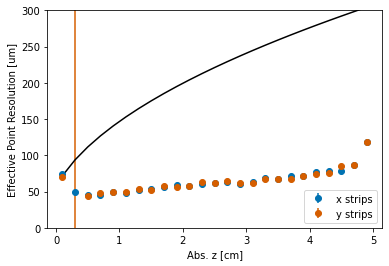

In [95]:
Charge_sharing = 1
Gain = 1000
pitch_x = 200
pitch_y = 200
n_strips_x = 500
n_strips_y = 500
electronic_gain_x = 4.5
electronic_gain_y = 4.5
drift_length = 5.0


# 3D clustering paramters
mu = T_off.iloc[4]["Mu"]
sigma = T_off.iloc[4]["Sigma"]
n_sigma = 3

# simulatue tracks
tracks = sim_p210(n_sims = 500, DL = drift_length, Diff = True, DTrans = 0.0135, DLong = 0.0129, W = 35.2)

# simulate readout
hits = sim_readout(tracks, peaking_time = 400, digit_t  = 250, pitch_x = pitch_x, pitch_y = pitch_y,thres_x = 0.0/electronic_gain_x*6241.5, thres_y =  0.0/electronic_gain_y*6241.5, CS = Charge_sharing, Gain = Gain, v_drift = 0.0008, Charge_integration = True, DL=drift_length, pitch_z = 0.02, G_x = electronic_gain_x, G_y = electronic_gain_x)
tracks = pd.concat([tracks,hits],axis=1)

# Reconstruct and get point resolutions
x_res, x_res_err, y_res, y_res_err, abs_z = get_PR_w_expected(tracks, mu = mu, sigma = sigma , n_sigma = n_sigma, DL =drift_length, G_x = electronic_gain_x, G_y = electronic_gain_y, n_strips_x = n_strips_x, n_strips_y=n_strips_y, pitch_x=pitch_x, pitch_y=pitch_y, theta_min = theta_min, theta_max = theta_max )




[  10.42539392   51.49829572  176.4855467   273.32450531  365.91800857
  463.77346299  549.51035271  685.11783628  781.41792035  864.44614646
 1025.04730321 1112.05815804 1243.91959886 1352.66660275 1468.88006667
 1546.33769813 1677.1629394  1774.27526841 1876.15629394 2026.44984941
 2143.93341981 2245.69259074 2356.48723098 2487.16114031 2606.45711518
 2674.61951313 2789.46632796 2911.54179492 3098.36956265 3187.83364679
 3168.79831953 3290.59439084 3398.42334607 3644.65704455 3811.48018777
 3833.76143881 4042.32118324 4048.88423034 4169.15144455 4240.11197575
 4463.56502077 4415.47739255 4603.87533076 4602.52436206 4920.84986924
 4941.91011554 4940.80953448 5261.96640122 5453.28202742 5329.57828747
 5606.1747454  5543.16056018 5878.11780875 5976.39833092 6067.26705324
 5954.63183667]


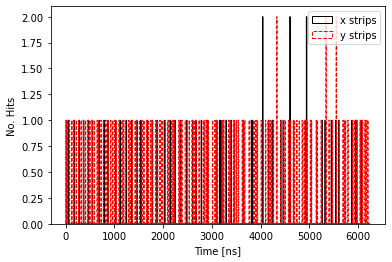

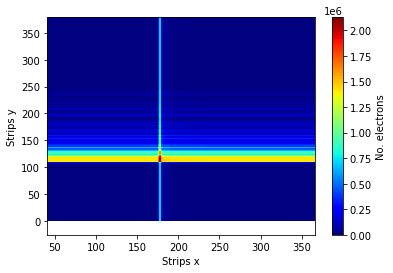

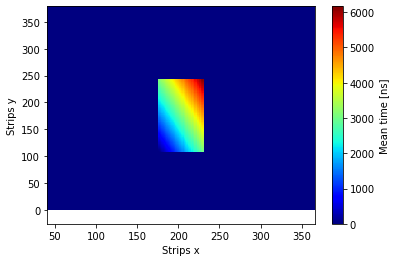

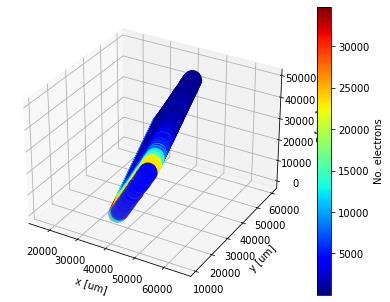

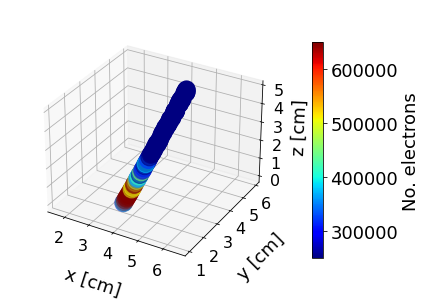

In [89]:
# 3D clustering paramters
mu = T_off.iloc[4]["Mu"]
sigma = T_off.iloc[4]["Sigma"]
n_sigma = 3

# Look at a single event after the cut
test_event = tracks.iloc[3]
# Make a TrackTools object for the event
dsp = stripROtools.TrackTools(event = test_event, Mult_factor = 1.0, gain_x=9, gain_y=4.5, v_drift=8.0)

# Plot 1D time display
dsp.TimeHistView( t_bin =10)

# Plot 2D displays of charge and time
dsp.Strip2DView(fullview = False)
dsp.Strip2DView_times(fullview = False)

# Plot 3D displays
dsp.Reconst3D_v0()
x,y,z,c = dsp.Reconst3D_v1( mu = mu, sigma = sigma , n_sigma = n_sigma,save_name = "sim_alpha")